In [234]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 10]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [235]:
#export

from exp.nb_03_early_stopping import *
torch.set_num_threads(2)

# ConvNet

In [4]:
x_train, y_train, x_valid, y_valid = get_data(url=MNIST_URL)

In [5]:
#export

def normalize_to(train, valid):
    mean = train.mean()
    std  = train.std()
    return normalize(train, mean, std), normalize(valid, mean, std)

In [6]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_valid, y_valid)

In [7]:
### checking if the normalization worked properly or not
### i.e. mean ~= 0 & std ~= 1

x_train.mean(), x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [8]:
nh = 50
bs = 512
c  = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs=bs), c=c)

```
To refactor layers, it's useful to have a Lambda layer that can take a basic function and convert it to a layer we can put inside "torch.nn.Sequential"

NOTE: if you use a Lambda layer with a "lambda" function, your model won't pickle so you won't be save it with PyTorch. So it's best to give a name to the function you are using inside your Lambda (like "flatten" below).
```

In [9]:
#export

class Lambda(torch.nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)

def flatten(x):
    return x.view(x.shape[0], -1)

def mnist_resize(x):
    return x.view(-1, 1, 28, 28)

In [10]:
### We can now define a simple CNN

def get_cnn_model(data):
    return torch.nn.Sequential(
        Lambda(func=mnist_resize),                                                           ### 28x28
        torch.nn.Conv2d( 1, 8,  kernel_size=5, padding=2, stride=2), torch.nn.ReLU(),        ### 14x14
        torch.nn.Conv2d( 8, 16, kernel_size=3, padding=2, stride=2), torch.nn.ReLU(),        ### 7x7
        torch.nn.Conv2d(16, 32, kernel_size=3, padding=2, stride=2), torch.nn.ReLU(),        ### 4x4
        torch.nn.Conv2d(32, 32, kernel_size=3, padding=2, stride=2), torch.nn.ReLU(),        ### 2x2
        torch.nn.AdaptiveAvgPool2d(1),
        Lambda(func=flatten),
        torch.nn.Linear(32, data.c)
    )

In [11]:
model = get_cnn_model(data)

In [12]:
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

In [236]:
### basic callbacks from previous notebook: imflash217__03_early_stopping.ipynb
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [14]:
opt = optim.SGD(params=model.parameters(), lr=0.4)
learner = Learner(model=model, opt=opt, loss_fn=loss_func, data=data)
run = Runner(cb_funcs=cbfs)

In [15]:
%time run.fit(epochs=1, learner=learner)

train: [2.30080625, tensor(0.1111)]
valid: [2.2997205078125, tensor(0.1064)]
CPU times: user 15.1 s, sys: 4.81 s, total: 19.9 s
Wall time: 7.76 s


# `CUDA`:

```
A simple callback can make sure the model, inputs & outputs are on the same device.
```

In [16]:
### Somewhat more flexible way
device = torch.device("cuda", 0)

In [17]:
device

device(type='cuda', index=0)

In [18]:
class CudaCallback(Callback):
    def __init__(self, device):
        self.device = device
    def begin_fit(self):
        self.model.to(self.device)
    def begin_batch(self):
        self.run.xb = self.xb.to(self.device)
        self.run.yb = self.yb.to(self.device)

In [19]:
### Somewhat less flexible but more convenient
torch.cuda.set_device(device)

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [20]:
#export

class CudaCallback(Callback):
    def begin_fit(self):
        self.model.cuda()
    def begin_batch(self):
        self.run.xb = self.xb.cuda()
        self.run.yb = self.yb.cuda()

In [21]:
cbfs.append(CudaCallback)

In [22]:
model = get_cnn_model(data=data)
opt = optim.SGD(params=model.parameters(), lr=0.4)
learner = Learner(model=model, opt=opt, loss_fn=loss_func, data=data)
run = Runner(cb_funcs=cbfs)

In [23]:
%time run.fit(epochs=1, learner=learner)

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

# Refactor `"model"`

```
1. First we can regroup all the conv/ReLU into a single function called "conv2d"
```

In [24]:
def conv2d(ni, nf, ks=3, stride=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, padding=ks//2, stride=stride),
        torch.nn.ReLU()
    )

In [25]:
#export

class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self, tfm):
        self.tfm = tfm
    def begin_batch(self):
        self.run.xb = self.tfm(self.xb)
        
def view_tfm(*size):
    def _inner(x):
        return x.view(*((-1,) + size))
    return _inner

In [237]:
mnist_view_tfm = view_tfm(1, 28, 28)
cbfs.append(partial(BatchTransformXCallback, mnist_view_tfm))

```
With the "AdaptiveAvgPool", this model can now work on any input size
```

In [27]:
nfs = [8, 16, 32, 32]         ### number of filters

In [28]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs                                  ### [1] is added for the initial input channels (in MNIST the inputs are 1-channel gray images)
    layers = [
        conv2d(ni=nfs[i], nf=nfs[i+1], ks=(5 if i==0 else 3))
        for i in range(len(nfs)-1)
    ] + [torch.nn.AdaptiveAvgPool2d(output_size=1),
         Lambda(flatten),
         torch.nn.Linear(in_features=nfs[-1], out_features=data.c)]
    return layers

def get_cnn_model(data, nfs):
    return torch.nn.Sequential(*get_cnn_layers(data, nfs))

In [29]:
get_cnn_model(data, nfs)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

```
And this helper function will quickly give us everything we needed to run the training.
```

In [30]:
#export

def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    if opt_func is None:
        opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learner = Learner(model, opt, loss_func, data)
    run = Runner(cb_funcs=listify(cbs))
    return learner, run

In [31]:
model = get_cnn_model(data, nfs)
learner, run = get_runner(model, data, lr=0.6, cbs=cbfs)

In [32]:
run.fit(epochs=1, learner=learner)

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [33]:
cbfs

[exp.nb_03_early_stopping.Recorder,
 functools.partial(<class 'exp.nb_03_early_stopping.AvgStatsCallback'>, <function accuracy at 0x7f4601322ef0>),
 __main__.CudaCallback,
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7f4588ea28c0>)]

# `HOOKS`

## Manual Insertion

```
Let's say we want to do some telemetry, and want the mean and standard-deviation of each activations in the model. First we can do it manually like this -->

```

In [70]:
class SequentialModel(torch.nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers    = torch.nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
        return x
    
    def __iter__(self):
        return iter(self.layers)

In [238]:
model = SequentialModel(*get_cnn_layers(data, nfs))
cbfs = [Recorder, partial(AvgStatsCallback, accuracy), partial(BatchTransformXCallback, mnist_view_tfm)]
learner, run = get_runner(model, data, lr=0.4, cbs=cbfs)

TypeError: get_cnn_layers() missing 1 required positional argument: 'layer'

In [72]:
run.fit(epochs=1, learner=learner)

train: [1.931415, tensor(0.3359)]
valid: [0.753647265625, tensor(0.7687)]


```
Now we can look at the means and stds of activations at the beginning of training
```

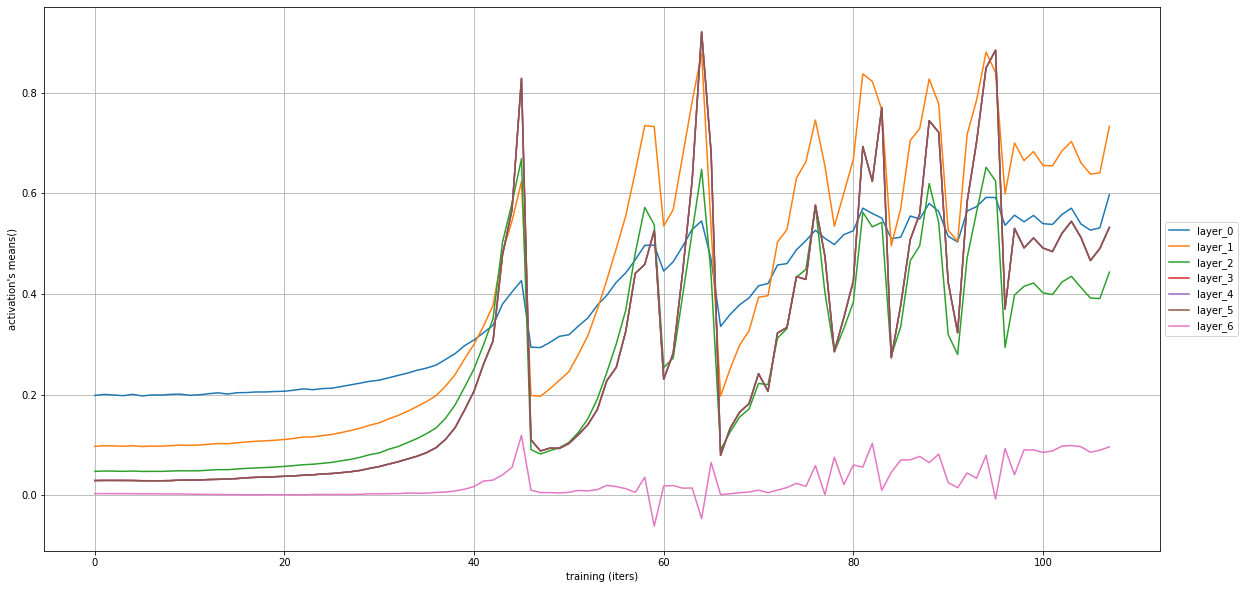

In [73]:
for i, l in enumerate(model.act_means):
    plt.plot(l, label=f"layer_{i}")
plt.xlabel("training (iters)")
plt.ylabel("activation's means()")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))            ### Put a legend below current axis

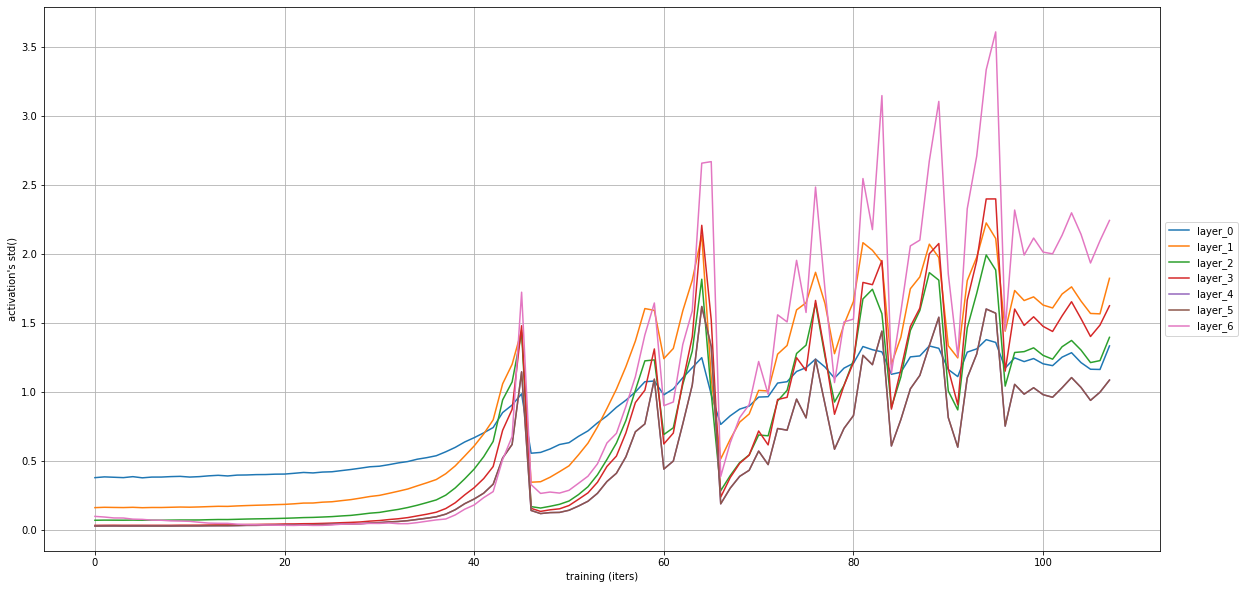

In [74]:
for i, l in enumerate(model.act_stds):
    plt.plot(l, label=f"layer_{i}")
plt.xlabel("training (iters)")
plt.ylabel("activation's std()")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))          ### Put a legend below current axis

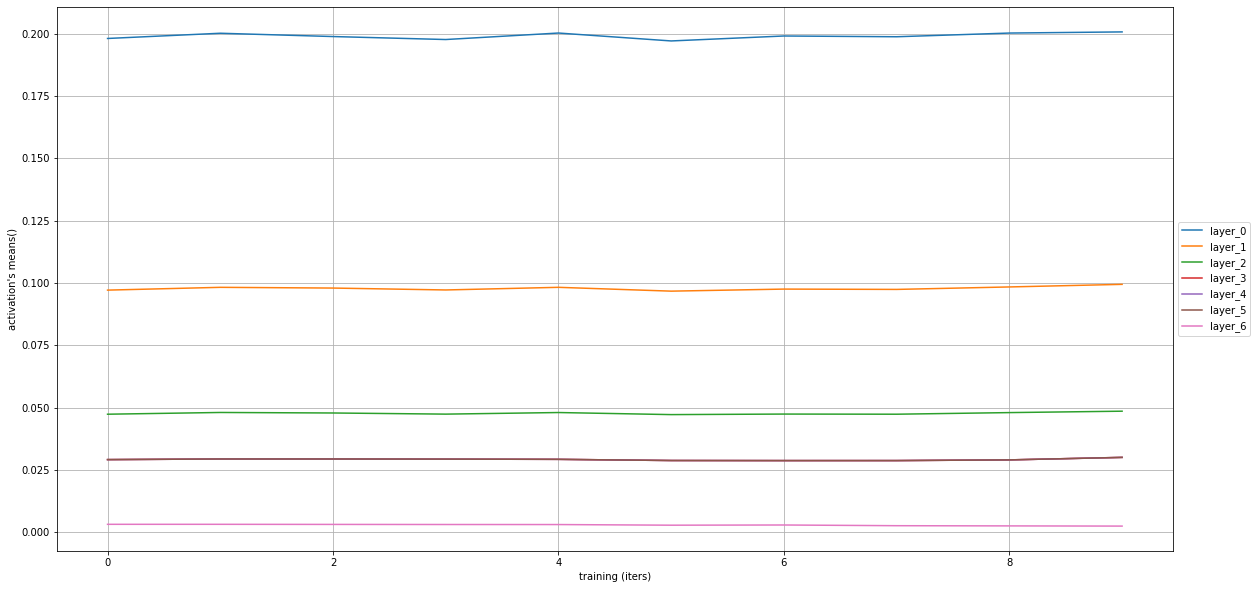

In [75]:
for i, l in enumerate(model.act_means):
    plt.plot(l[:10], label=f"layer_{i}")
plt.xlabel("training (iters)")
plt.ylabel("activation's means()")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))          ### Put a legend below current axis

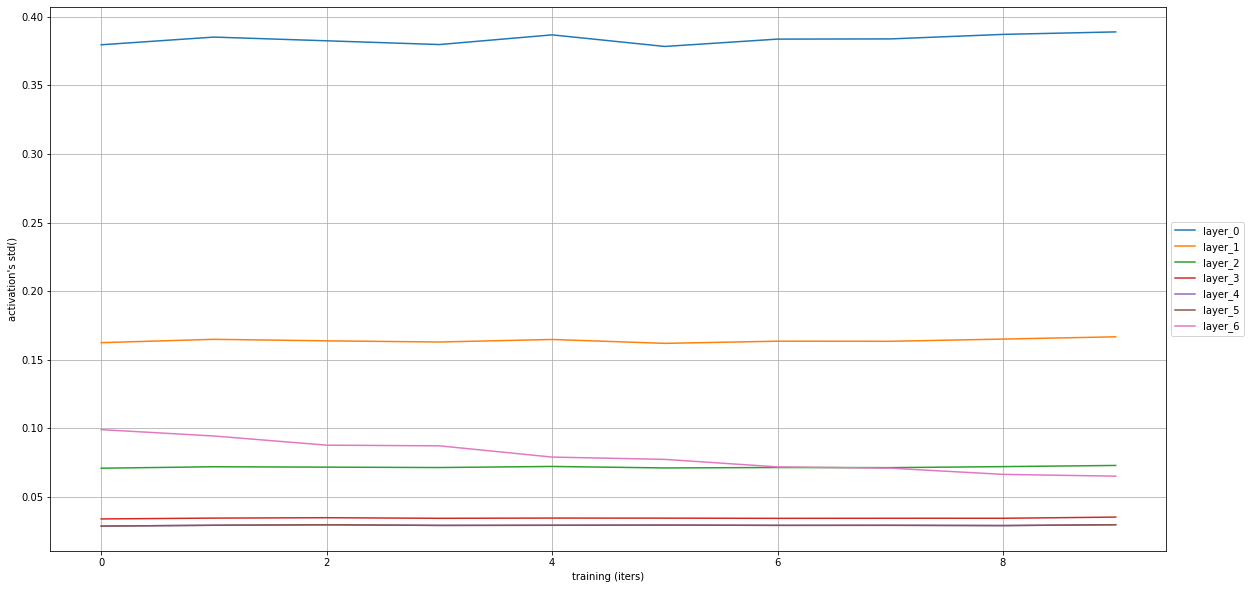

In [76]:
for i, l in enumerate(model.act_stds):
    plt.plot(l[:10], label=f"layer_{i}")
plt.xlabel("training (iters)")
plt.ylabel("activation's std()")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))          ### Put a legend below current axis

## Pytorch Hooks
```
1. Hooks are PyTorch object you can add to any torch.nn.Module.
2. A hook will be called when a layer, it is registered to, is called during:
    a. forward pass  --> Forward Hook
    b. backward pass --> Backward Hook
3. Hooks don't require us to rewrite our model.
```

In [77]:
model = get_cnn_model(data, nfs)
learner, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [78]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

```
A hook is attached to a layer and needs to have a function that takes three arguments: module, input & output.
Here we store the mean and standard deviation in the correct position of our lists.
```

In [79]:
def append_stats(i, module, inp, out):
    act_means[i].append(out.data.mean())
    act_stds[i].append(out.data.std())

In [80]:
for i, m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

In [81]:
run.fit(epochs=1, learner=learner)

train: [1.9276321875, tensor(0.3331)]
valid: [0.680954248046875, tensor(0.8071)]


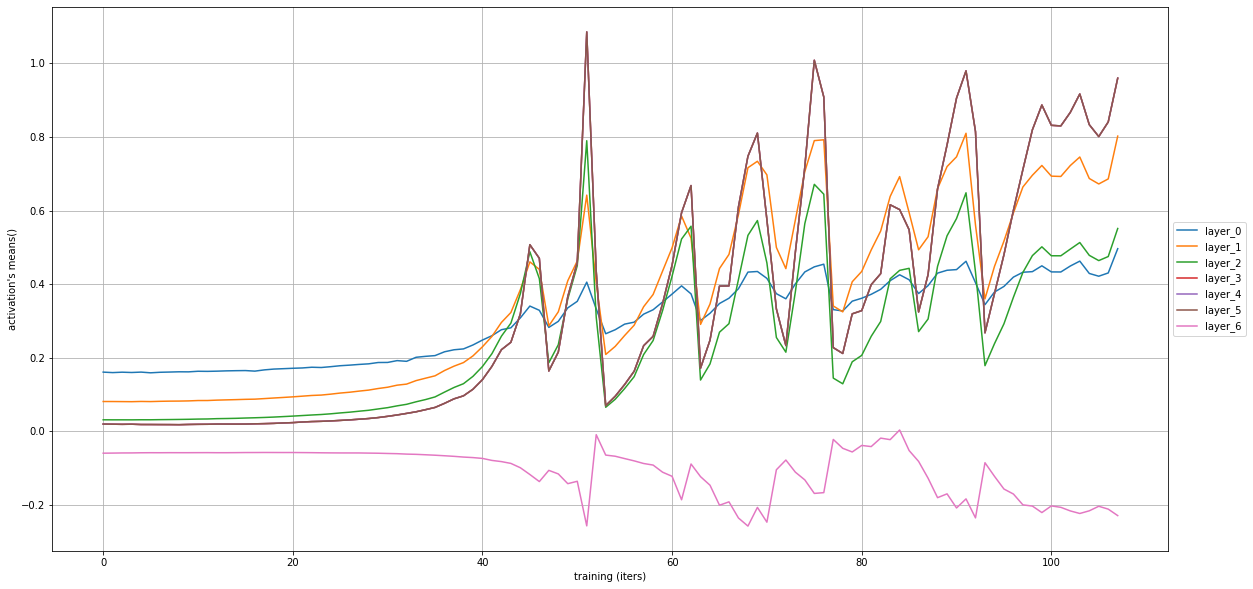

In [82]:
for i, l in enumerate(act_means):
    plt.plot(l, label=f"layer_{i}")
plt.xlabel("training (iters)")
plt.ylabel("activation's means()")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))         ### Put a legend below current axis

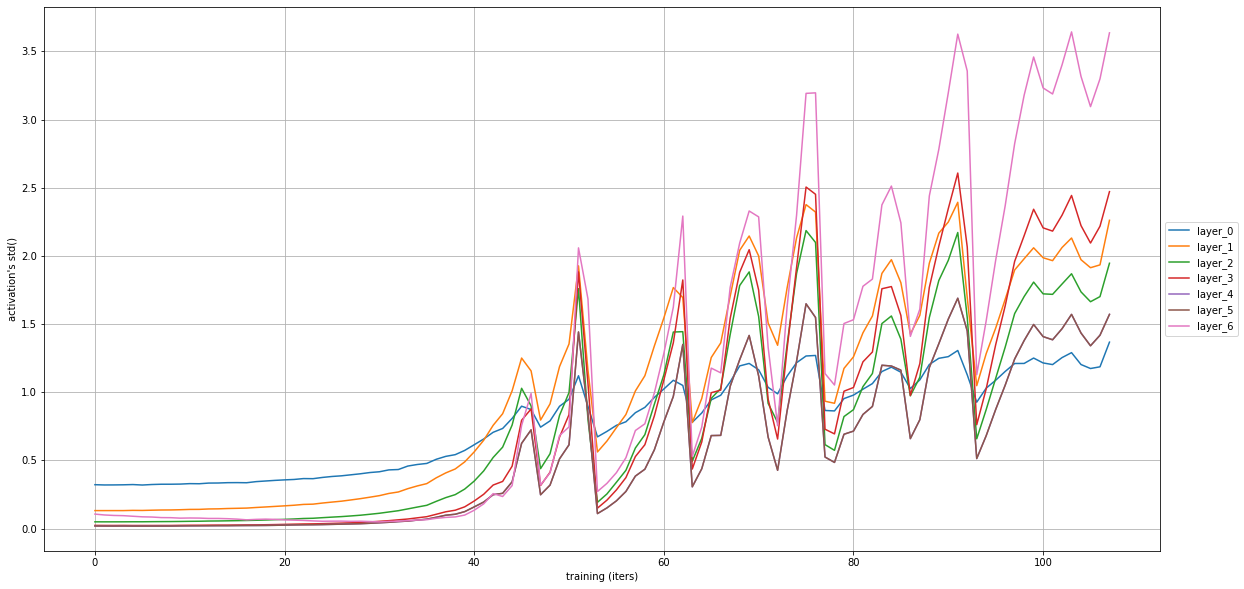

In [83]:
for i, l in enumerate(act_stds):
    plt.plot(l, label=f"layer_{i}")
plt.xlabel("training (iters)")
plt.ylabel("activation's std()")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))            ### Put a legend below current axis

## Hook class
```
1. We can refactor the above function into a Hook class.
2. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and memory won't be released when the model is deleted.
```

In [84]:
#export

def children(module):
    return list(module.children())

class Hook():
    def __init__(self, module, func):
        self.hook = module.register_forward_hook(partial(func, self))
    def remove(self):
        self.hook.remove()
    def __del__(self):
        self.remove()
        
def append_stats(hook, module, inp, out):
    if not hasattr(hook, "stats"):
        hook.stats = ([], [])
    means, stds = hook.stats
    means.append(out.data.mean())
    stds.append(out.data.std())
    

In [85]:
model = get_cnn_model(data, nfs)
learner, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [86]:
hooks = [Hook(l, append_stats) for l in children(model)]

In [87]:
run.fit(epochs=1, learner=learner)

train: [1.8776684375, tensor(0.3499)]
valid: [0.640847802734375, tensor(0.7987)]


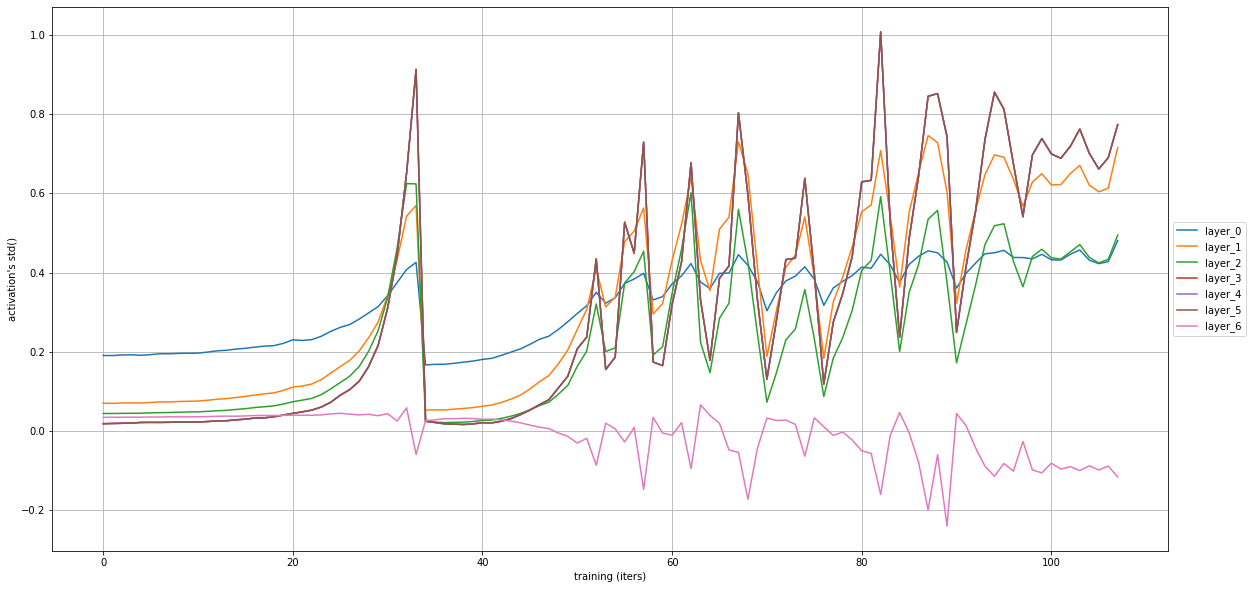

In [88]:
for i, h in enumerate(hooks):
    plt.plot(h.stats[0], label=f"layer_{i}")                      ### Plotting the activations MEAN
    h.remove()
plt.xlabel("training (iters)")
plt.ylabel("activation's std()")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))            ### Put a legend below current axis

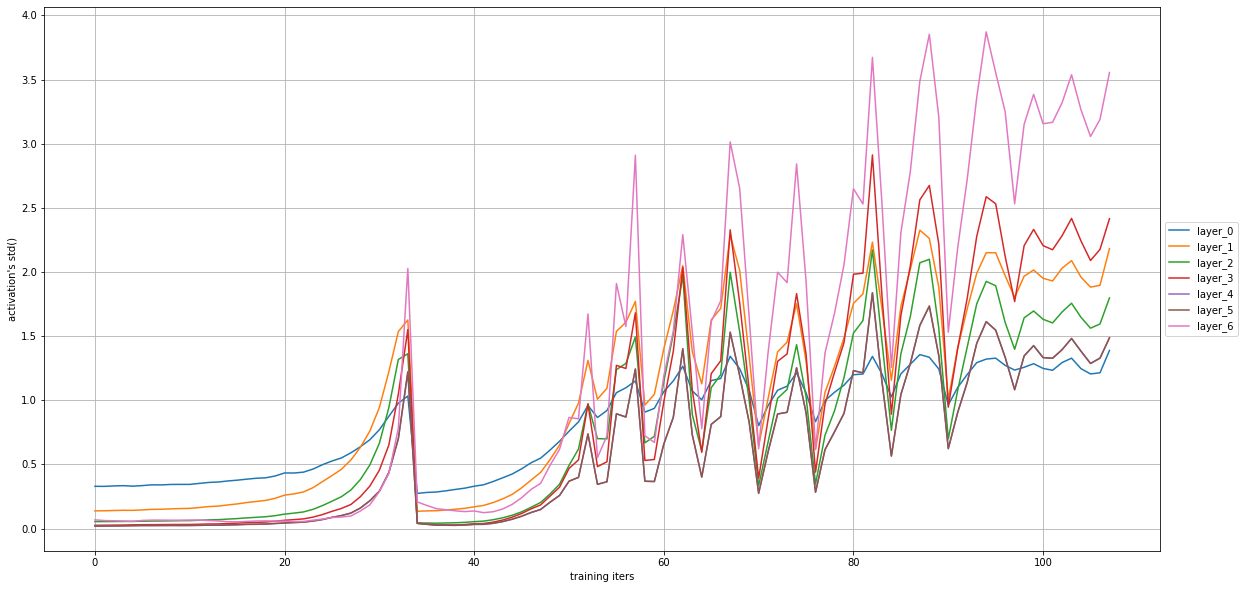

In [89]:
for i, h in enumerate(hooks):
    plt.plot(h.stats[1], label=f"layer_{i}")                         ### plotting the activations STD
    h.remove()
plt.xlabel("training iters")
plt.ylabel("activation's std()")
plt.grid()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

## A Hooks class

```
Let's design our own class that can contain a list of objects.
It will behave a bit like numpy array in the sense that we can index into it via:
1. a single index
2. a slice (like 1:5)
3. a list of indices
4. a mask of indices (eg. [True, False, False, True, True,...])

The __iter__ method is there to be able to iterate over that object (eg. "for x in ....")
```

In [128]:
#export

class ListContainer():
    def __init__(self, items):
        self.items = listify(items)
    def __len__(self):
        return len(self.items)
    def __getitem__(self, idx):
        if isinstance(idx, (int, slice)):                         ### int or slice indexing
            return self.items[idx]
        if isinstance(idx[0], bool):                              ### boolean mask indexing
            assert len(idx) == len(self)                          ### checking if "idx" is a boolean mask of same length
            return [x for msk, x in zip(idx, self.items) if msk]
        return [self.items[i] for i in idx]                       ### list of indices indexing
    def __iter__(self):
        return iter(self.items)
    def __setitem__(self, idx, x):
        self.items[idx] = x
    def __delitem__(self, idx):
        del(self.items[idx])
    def __repr__(self):
        result = f"{self.__class__.__name__}({len(self)} items)\n{self.items[:10]}"
        if len(self)>10:
            result = result[:-1] + ", ...]"
        return result            
            

In [91]:
ListContainer(range(10))

ListContainer(10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [92]:
ListContainer(range(100))

ListContainer(100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...]

In [93]:
t = ListContainer(range(10))

In [94]:
t[[1,2]]

[1, 2]

In [95]:
t[[False]*8 + [True, False]]

[8]

```
We can use "ListContainer" class to write a "Hooks" class that contain several hooks.
We will also use it in the next notebook as a container for our objects in the "data blocks" API.
```

In [136]:
#export

from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, modules, func):
        super().__init__([Hook(m, func) for m in modules])         ### initializing the parent ListContainer
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        return self.remove()                                       ### removing the hook on exit
    def __del__(self):
        self.remove()                                              ### removing the hook on delete
        
    def __delitem__(self, idx):
        self[idx].remove()                                         ### removingg the particular hook
        super().__delitem__(idx)                                   ### deleting the parent ListContainer item
    
    def remove(self):
        for hook in self:
            hook.remove()
        

In [97]:
cbfs

[exp.nb_03_early_stopping.Recorder,
 functools.partial(<class 'exp.nb_03_early_stopping.AvgStatsCallback'>, <function accuracy at 0x7f4601322ef0>),
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7f4588ea28c0>)]

In [98]:
model = get_cnn_model(data, nfs)
learner, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [99]:
hooks = Hooks(modules=model, func=append_stats)
hooks

Hooks(7 items)
[<__main__.Hook object at 0x7f4579f45dd0>, <__main__.Hook object at 0x7f4579ef2d50>, <__main__.Hook object at 0x7f4579ef2590>, <__main__.Hook object at 0x7f4579e96290>, <__main__.Hook object at 0x7f4579e96390>, <__main__.Hook object at 0x7f4579e96250>, <__main__.Hook object at 0x7f4579e96610>]

In [100]:
hooks.remove()

In [101]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x)

In [102]:
x.mean(), x.std()

(tensor(0.0064), tensor(1.0065))

In [103]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.2190, grad_fn=<MeanBackward0>),
 tensor(0.4110, grad_fn=<StdBackward0>))

In [104]:
for l in model:
    if isinstance(l, torch.nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

```
Having given and __enter__ and __exit__ method to our Hooks class; we can use it as a comtext manager in "with" block.
This makes sure that when we exit the "with" block, all the hooks have been removed and aren't there to pollute our memory.
```

train: [1.280183671875, tensor(0.5896)]
valid: [0.71931904296875, tensor(0.8082)]


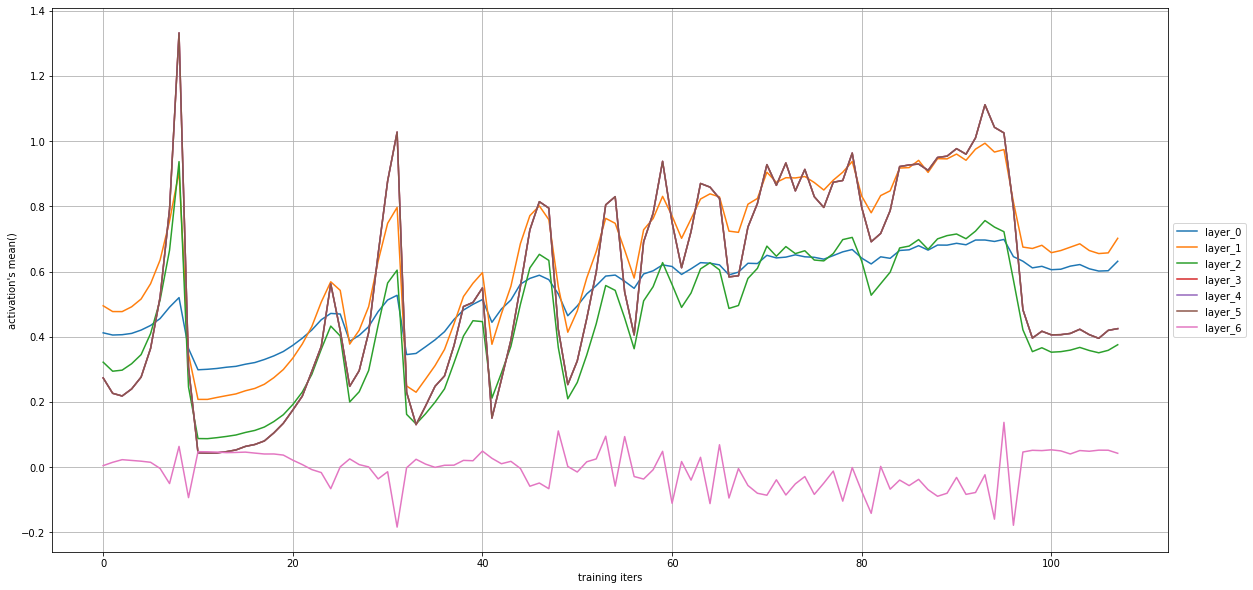

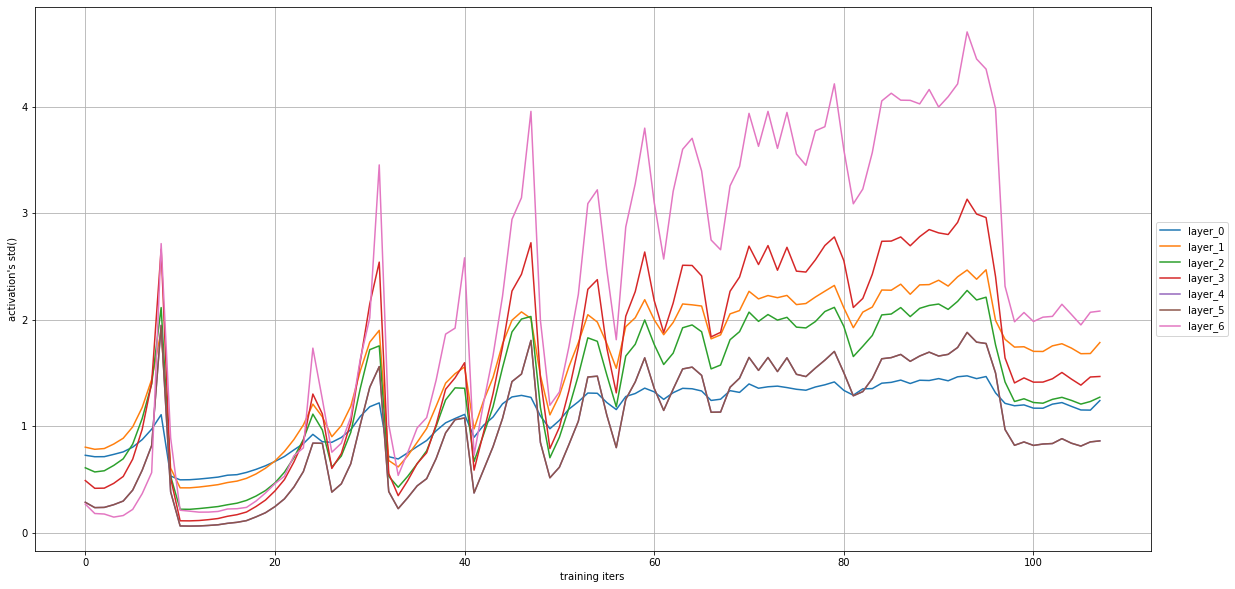

In [105]:
with Hooks(modules=model, func=append_stats) as hooks:
    run.fit(epochs=1, learner=learner)
    for i, h in enumerate(hooks):
        means, _ = h.stats
        plt.plot(means, label=f"layer_{i}")                         ### plotting the activations MEANS
    plt.xlabel("training iters")
    plt.ylabel("activation's mean()")
    plt.grid()
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        
    plt.figure()
    for i, h in enumerate(hooks):
        _, stds = h.stats
        plt.plot(stds, label=f"layer_{i}")                          ### plotting the activations STDS
    plt.xlabel("training iters")
    plt.ylabel("activation's std()")
    plt.grid()
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        
    

## Other statistics

```
Lets store more than our mean and std.
Lets plot HISTOGRAMS of our activations now.
```

In [106]:
def append_stats(hook, module, inp, out):
    if not hasattr(hook, "stats"):
        hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(out.data.mean().cpu())
    stds.append(out.data.std().cpu)
    hists.append(out.data.cpu().histc(40, 0, 10))                ### histc() isn't implemented on GPU, so we need to bring the data to CPU first then compute histc()

In [137]:
model = get_cnn_model(data, nfs)
learner, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [138]:
### doing Kaiming/He weight initialization
for l in model:
    if isinstance(l, torch.nn.Sequential):
        init.kaiming_normal_(l[0].weight)               ### initializing only the CNN layer (not the ReLU layer)
        l[0].bias.data.zero_()                          ### initializing BIAS to zero
        

In [139]:
hooks

Hooks(7 items)
[<__main__.Hook object at 0x7f4578bffb90>, <__main__.Hook object at 0x7f4578bffe50>, <__main__.Hook object at 0x7f45783604d0>, <__main__.Hook object at 0x7f4578360f10>, <__main__.Hook object at 0x7f4578360ed0>, <__main__.Hook object at 0x7f45783603d0>, <__main__.Hook object at 0x7f4578360890>]

In [140]:
### creating hooks inside the context manager & running the model
### after the "with" context ends, the rhooks are removed but the values are stored in the "hooks" variable
### as mentioned/named below

with Hooks(model, append_stats) as hooks:
    run.fit(epochs=1, learner=learner)

train: [1.48003375, tensor(0.4894)]
valid: [0.45441201171875, tensor(0.8367)]


In [141]:
hooks

Hooks(7 items)
[<__main__.Hook object at 0x7f456a891410>, <__main__.Hook object at 0x7f456a8918d0>, <__main__.Hook object at 0x7f456a8914d0>, <__main__.Hook object at 0x7f456a934a90>, <__main__.Hook object at 0x7f456a934d90>, <__main__.Hook object at 0x7f45783605d0>, <__main__.Hook object at 0x7f4578360790>]

In [142]:
hooksX

Hooks(7 items)
[<__main__.Hook object at 0x7f45790486d0>, <__main__.Hook object at 0x7f4579048ed0>, <__main__.Hook object at 0x7f4579048e50>, <__main__.Hook object at 0x7f4579048d90>, <__main__.Hook object at 0x7f4579048e90>, <__main__.Hook object at 0x7f4579048bd0>, <__main__.Hook object at 0x7f45790da210>]

In [147]:
def get_hist(hook):
    return torch.stack(hook.stats[2]).t().float().log1p()

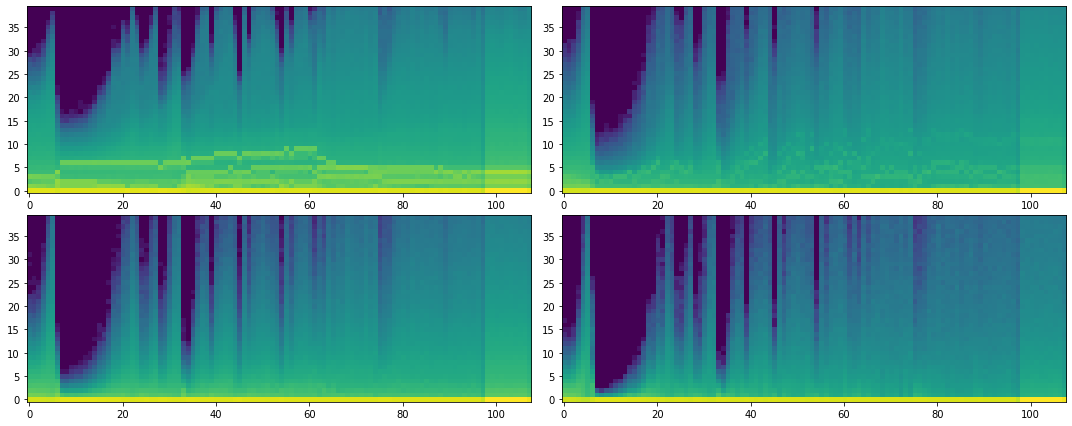

In [183]:
i = 0
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
for ax, hook in zip(axes.flatten(), hooks[:4]):               ### plotting only for first 4 layers
    ax.imshow(get_hist(hook), origin="lower")
    ax.set_xlabel("training iters")
    ax.set_ylabel("bins")
    ax.set_title(f"layer_{i}")
    i += 1
plt.tight_layout()

In [149]:
axes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f456a6de850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f456a5e0610>]], dtype=object)

In [150]:
axes.flatten()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f456a6de850>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f456a5e0610>], dtype=object)

```
From HISTOGRAMS we can easily get more information about the min and max of the activations
```

In [176]:
def get_min(hook):
    h1 = torch.stack(hook.stats[2]).t().float()
    return h1[:2].sum(dim=0) / h1.sum(dim=0)                  ### %age of data-points in the 1st two bins (the ones that are nearer to zero)


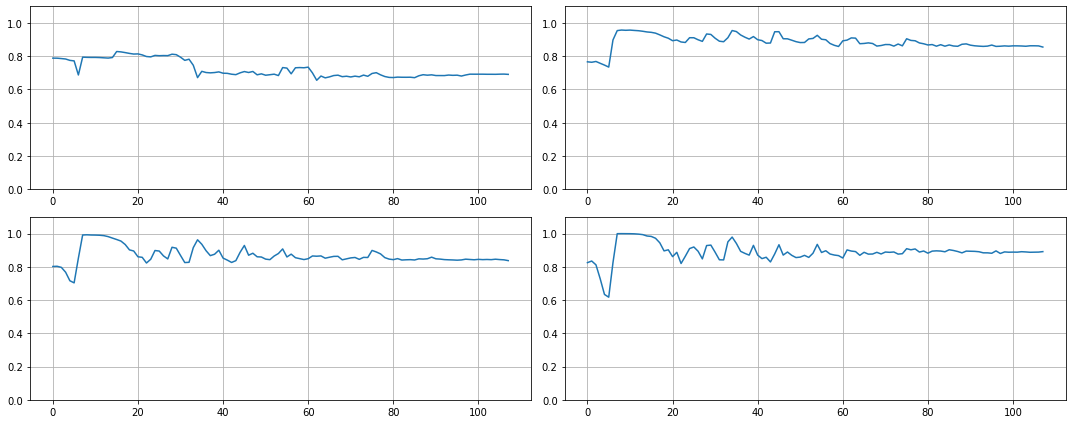

In [182]:
i = 0
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,6))
for ax, hook in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(hook))
    ax.set_ylim(0,1.1)
    ax.grid()
    ax.set_xlabel("training iters")
    ax.set_ylabel("%age")
    ax.set_title(f"layer_{i}")
    i += 1
plt.tight_layout()

```
The above plot suggests that most of the distribution resides in lower two bins of the histogram
i.e. most (> 80%) of the activations (in almost every layer) have a value close to ZERO.

And as the training iterations increase, the %age increases to ~> 90%
This suggests that our networks don't learn anything significant.
```

In [152]:
hook.stats[2]

[tensor([4.6614e+04, 7.4740e+03, 4.8540e+03, 2.8670e+03, 1.6190e+03, 9.0800e+02,
         5.3100e+02, 3.1300e+02, 1.6600e+02, 8.4000e+01, 4.4000e+01, 3.6000e+01,
         1.4000e+01, 7.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 tensor([4.7673e+04, 7.0550e+03, 4.6150e+03, 2.7550e+03, 1.5300e+03, 8.4000e+02,
         4.9800e+02, 2.5500e+02, 1.4000e+02, 8.0000e+01, 4.3000e+01, 3.1000e+01,
         1.3000e+01, 6.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

In [154]:
torch.stack(hook.stats[2])

tensor([[4.6614e+04, 7.4740e+03, 4.8540e+03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.7673e+04, 7.0550e+03, 4.6150e+03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.6279e+04, 6.9500e+03, 4.6840e+03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.1259e+05, 1.7740e+03, 1.4550e+03,  ..., 1.2600e+02, 1.0800e+02,
         1.1000e+02],
        [1.1266e+05, 1.5780e+03, 1.3560e+03,  ..., 1.4700e+02, 1.0900e+02,
         1.1100e+02],
        [8.6499e+04, 1.1540e+03, 1.0280e+03,  ..., 1.2100e+02, 1.1300e+02,
         9.2000e+01]])

In [157]:
torch.stack(hook.stats[2]).t().float().shape

torch.Size([40, 108])

In [158]:
torch.stack(hook.stats[2]).t().float()[:2]

tensor([[ 46614.,  47673.,  46279.,  41818.,  37361.,  37522.,  51004.,  64812.,
          65150.,  64999.,  65020.,  64671.,  64129.,  63186.,  61551.,  61854.,
          60289.,  57556.,  54817.,  55603.,  53470.,  55883.,  51741.,  54796.,
          57284.,  57838.,  56681.,  53231.,  58089.,  58481.,  56170.,  53334.,
          52549.,  57870.,  61989.,  58840.,  56110.,  56010.,  54822.,  58690.,
          55266.,  53743.,  54658.,  52215.,  55845.,  59032.,  55821.,  56463.,
          55459.,  54719.,  54663.,  55482.,  54318.,  56003.,  59377.,  56607.,
          57137.,  56061.,  55571.,  55148.,  54185.,  57783.,  56752.,  56581.,
          55134.,  56533.,  55822.,  56000.,  56197.,  55834.,  56680.,  56581.,
          56244.,  55735.,  55524.,  57603.,  57383.,  58059.,  56724.,  57092.,
          56034.,  57110.,  56758.,  56784.,  56391.,  57262.,  57034.,  56569.,
          56119.,  57187.,  56754.,  56501.,  56327.,  55839.,  56000.,  55993.,
          56570.,  36635., 1

In [159]:
torch.stack(hook.stats[2]).t().float()[:2].sum(dim=0)

tensor([ 54088.,  54728.,  53229.,  47709.,  41546.,  40020.,  54121.,  65513.,
         65530.,  65515.,  65503.,  65458.,  65336.,  65137.,  64595.,  64427.,
         63700.,  61916.,  58730.,  59147.,  56462.,  58162.,  53628.,  56569.,
         59645.,  60266.,  58582.,  55503.,  60828.,  61006.,  58149.,  54936.,
         54223.,  62283.,  64173.,  61654.,  58538.,  57726.,  57006.,  60901.,
         57051.,  55608.,  56129.,  54170.,  57430.,  61150.,  56935.,  58270.,
         56855.,  55899.,  55909.,  56680.,  56024.,  57668.,  61291.,  57892.,
         58751.,  57243.,  56592.,  56194.,  55706.,  59086.,  58339.,  58413.,
         56359.,  57982.,  56882.,  57086.,  56938.,  56794.,  57625.,  57644.,
         56895.,  56911.,  56319.,  59533.,  59080.,  59352.,  57856.,  58043.,
         56921.,  57993.,  57477.,  57631.,  57143.,  58017.,  57791.,  57328.,
         57112.,  58267.,  57514.,  57313.,  57075.,  56652.,  56852.,  56906.,
         57328.,  37203., 114405., 11416

In [160]:
torch.stack(hook.stats[2]).t().float().sum(dim=0)

tensor([ 65536.,  65536.,  65536.,  65536.,  65523.,  64813.,  65536.,  65536.,
         65536.,  65536.,  65536.,  65536.,  65536.,  65536.,  65536.,  65536.,
         65536.,  65536.,  65536.,  65536.,  65536.,  65536.,  65381.,  65470.,
         65536.,  65536.,  65536.,  65450.,  65536.,  65536.,  65487.,  65212.,
         64409.,  65536.,  65536.,  65536.,  65532.,  65521.,  65477.,  65536.,
         65517.,  65454.,  65438.,  65298.,  65427.,  65536.,  65374.,  65527.,
         65396.,  65309.,  65113.,  65209.,  65377.,  65370.,  65536.,  65306.,
         65504.,  65246.,  64966.,  64768.,  65291.,  65506.,  65180.,  65496.,
         64822.,  65325.,  64888.,  65076.,  64158.,  64712.,  64803.,  64958.,
         63966.,  64910.,  64057.,  65472.,  65449.,  65387.,  65077.,  64828.,
         64520.,  64819.,  64124.,  64390.,  64150.,  64257.,  64319.,  64240.,
         64594.,  65121.,  64339.,  64164.,  64061.,  64057.,  64290.,  64531.,
         63973.,  42249., 128555., 12854

In [162]:
torch.histc??

In [166]:
len(hook.stats[2])

108

# Generalized ReLU:
```
Now let's use our model with a generalized ReLU that can be shifted and with maximum value
```

In [199]:
#export

def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
            torch.nn.AdaptiveAvgPool2d(1),
            Lambda(flatten),
            torch.nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return torch.nn.Sequential(
            torch.nn.Conv2d(ni, nf, ks, stride=stride, padding=ks//2),
            GeneralReLU(**kwargs))

class GeneralReLU(torch.nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak = leak                                  ### amount of negative-slope in the ReLU
        self.sub  = sub                                   ### amount to subtract from the activations
        self.maxv = maxv                                  ### maximum allowed value of the activations
        
    def forward(self, x):
        x = F.leaky_relu(input=x, negative_slope=self.leak) if self.leak is not None else F.relu(input=x)
        if self.sub is not None:
            x.sub_(self.sub)
        if self.maxv is not None:
            x.clamp_max_(self.maxv)
        return x

def init_cnn(model, uniform=False):
    func = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for layer in model:
        if isinstance(layer, torch.nn.Sequential):
            func(layer[0].weight, a=0.1)                   ### initializing only the conv layer not the ReLU layer
            layer[0].bias.data.zero_()                     ### zeroing the bias of the conv layer
            
def get_cnn_model(data, nfs, layer, **kwargs):
    return torch.nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))


In [200]:
def append_stats(hook, module, inp, out):
    if not hasattr(hook, "stats"):
        hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(out.data.mean().cpu())
    stds.append(out.data.std().cpu())
    hists.append(out.data.cpu().histc(40, -7, 7))

In [206]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model=model, uniform=False)                       ### uniform=False means "Kaiming_normal" instead of "Kaiming_uniform"
learner, run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.5485077734375, tensor(0.8281)]
valid: [0.1473789794921875, tensor(0.9589)]


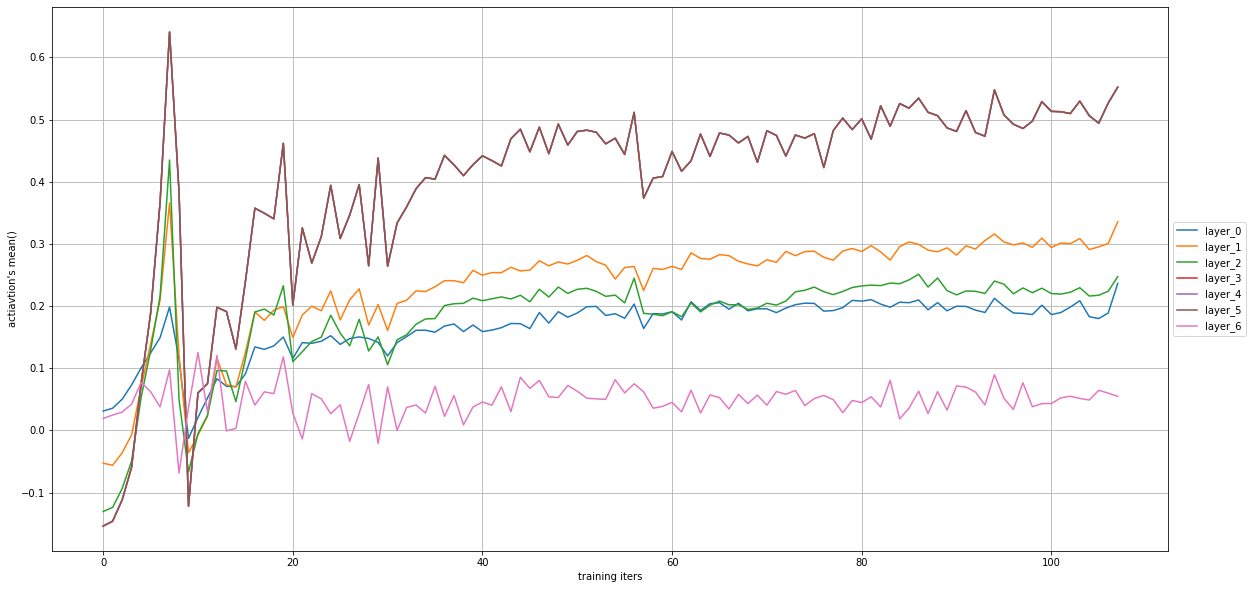

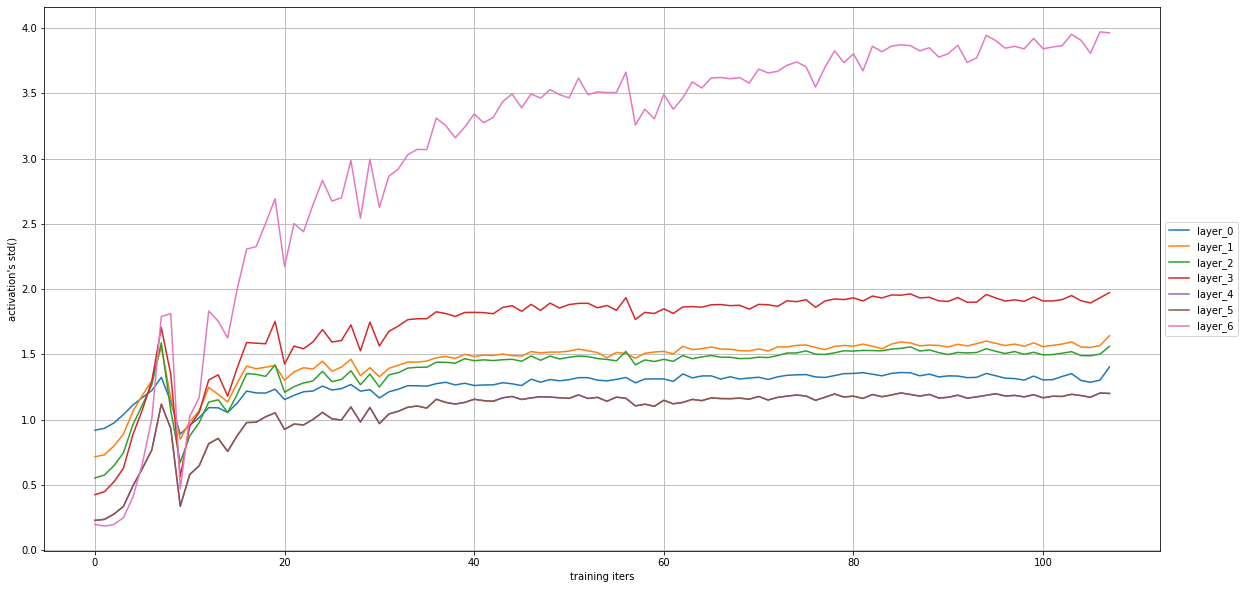

In [207]:
with Hooks(modules=model, func=append_stats) as hooks:
    run.fit(epochs=1, learner=learner)
    for i, h in enumerate(hooks):
        means, *_ = h.stats
        plt.plot(means, label=f"layer_{i}")
    plt.xlabel("training iters")
    plt.ylabel("actiavtion's mean()")
    plt.grid()
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.figure()
    for i, h in enumerate(hooks):
        _, stds, _ = h.stats
        plt.plot(stds, label=f"layer_{i}")
    plt.xlabel("training iters")
    plt.ylabel("activation's std()")
    plt.grid()
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5))

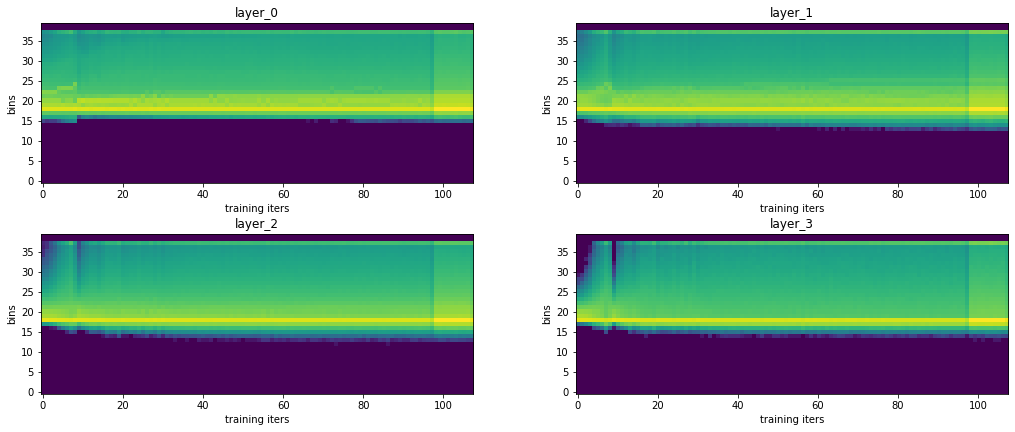

In [220]:
i = 0
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin="lower")
    ax.set_xlabel("training iters")
    ax.set_ylabel("bins")
    ax.set_title(f"layer_{i}")
    i += 1
plt.tight_layout()

In [214]:
def get_min(hook):
    h1 = torch.stack(hook.stats[2]).t().float()
    return h1[19:22].sum(dim=0) / h1.sum(dim=0)             ### %age if activations having zero value


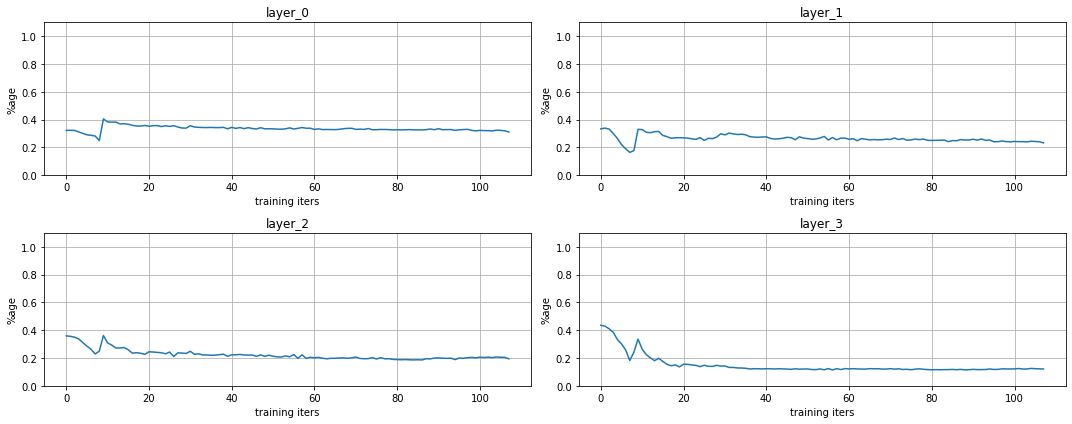

In [223]:
i = 0
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):                ### checking only the initial 4 layers
    ax.plot(get_min(h))
    ax.set_ylim(0, 1.1)
    ax.set_xlabel("training iters")
    ax.set_ylabel("%age")
    ax.set_title(f"layer_{i}")
    ax.grid()
    i += 1
plt.tight_layout()   
    

In [240]:
#export

def get_learn_run(data, nfs, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [241]:
sched = combine_scheds(pcts=[0.5, 0.5], scheds=[sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [242]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy), partial(BatchTransformXCallback, mnist_view_tfm)]

In [243]:
learner, run = get_learn_run(data, nfs, lr=0.9, layer=conv_layer, 
                             cbs=cbfs+[partial(ParamScheduler, "lr", sched)])

In [244]:
run.fit(epochs=5, learner=learner)

epoch=[0/5]:	train: [1.32809828125, tensor(0.5818)]	valid: [0.3466822998046875, tensor(0.8915)]
epoch=[1/5]:	train: [0.471301171875, tensor(0.8655)]	valid: [2.015011328125, tensor(0.3445)]
epoch=[2/5]:	train: [0.6550209765625, tensor(0.7891)]	valid: [0.1562230224609375, tensor(0.9509)]
epoch=[3/5]:	train: [0.123357412109375, tensor(0.9625)]	valid: [0.10062635498046875, tensor(0.9699)]
epoch=[4/5]:	train: [0.08790875, tensor(0.9725)]	valid: [0.08943438110351562, tensor(0.9727)]


```
Various researchers suggest that "Uniform init" may provide more useful initial weights than "normal init";
because "normal distribution" puts a lot of data-points around 0
```

In [249]:
learner, run = get_learn_run(data, nfs, lr=0.9, layer=conv_layer, uniform=True,
                             cbs=cbfs+[partial(ParamScheduler, "lr", sched)])

run.fit(epochs=5, learner=learner)

epoch=[0/5]:	train: [1.20072828125, tensor(0.6348)]	valid: [0.586123876953125, tensor(0.8208)]
epoch=[1/5]:	train: [0.391370859375, tensor(0.8799)]	valid: [0.16904136962890626, tensor(0.9500)]
epoch=[2/5]:	train: [0.1486516015625, tensor(0.9556)]	valid: [0.10227539672851563, tensor(0.9683)]
epoch=[3/5]:	train: [0.0858221875, tensor(0.9733)]	valid: [0.08027073974609375, tensor(0.9758)]
epoch=[4/5]:	train: [0.0601592626953125, tensor(0.9820)]	valid: [0.07256965942382812, tensor(0.9789)]


```
If we compare the above results of training for 5 epochs each on "normal" and "uniform" init,
we find that the performances donot vary much. 
But, we need to do much more rigrous experiments to come to any firm conclusion.
```

# Export

```
Here is a handy way to export our module without needeing to update the filename.
After we define this function, we can just call "nb_auto_export()" in the future notebooks.

In [258]:
# #export

# from IPython.display import display, Javascript
# def nb_auto_export():
#     display(Javascript("""{
# const ip = IPython.notebook
# if (ip) {
#     ip.save_notebook()
#     console.log('a')
#     const s = `!python notebook2script.py ${ip.notebook_name}`
#     if (ip.kernel) { ip.kernel.execute(s) }
# }
# }"""))

In [261]:
# nb_auto_export()

<IPython.core.display.Javascript object>

In [263]:
!python notebook_to_script.py imflash217__03_cuda_cnn_hooks_init.ipynb

Converted imflash217__03_cuda_cnn_hooks_init.ipynb to exp/nb_03_cuda_cnn_hooks_init.py
Converted imflash217__03_cuda_cnn_hooks_init.ipynb to exp/nb_03_cuda_cnn_hooks_init.py
Converted imflash217__03_cuda_cnn_hooks_init.ipynb to exp/nb_03_cuda_cnn_hooks_init.py
Converted imflash217__03_cuda_cnn_hooks_init.ipynb to exp/nb_03_cuda_cnn_hooks_init.py
Converted imflash217__03_cuda_cnn_hooks_init.ipynb to exp/nb_03_cuda_cnn_hooks_init.py
Converted imflash217__03_cuda_cnn_hooks_init.ipynb to exp/nb_03_cuda_cnn_hooks_init.py
Converted imflash217__03_cuda_cnn_hooks_init.ipynb to exp/nb_03_cuda_cnn_hooks_init.py
Converted imflash217__03_cuda_cnn_hooks_init.ipynb to exp/nb_03_cuda_cnn_hooks_init.py
Converted imflash217__03_cuda_cnn_hooks_init.ipynb to exp/nb_03_cuda_cnn_hooks_init.py
Converted imflash217__03_cuda_cnn_hooks_init.ipynb to exp/nb_03_cuda_cnn_hooks_init.py
Converted imflash217__03_cuda_cnn_hooks_init.ipynb to exp/nb_03_cuda_cnn_hooks_init.py
Converted imflash217__03_cuda_cnn_hooks_ini